# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
import os

In [3]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa

In [4]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn

In [5]:
!pip install -U -q segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


# Data Preprocessing

In [6]:
# Connecting to Google Drive
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'gtFine')
drive.mount(MOUNTPOINT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
# /content/gdrive/MyDrive/gtFine

In [8]:
# Function to fetch the original image path with parameter "a" which species the folder (train , val, test) from where
# we fetch the path. Returns the list of all images from given folder
def get_image_path(a): 
    image_path = []

    city_path = "/content/gdrive/MyDrive/gtFine" +"/"+ str(a)

    for city in os.listdir(city_path):

        file_path = city_path +"/"+city

        for file in os.listdir(file_path):

            s = file.split("_")

            if s[-1] == "color.png":
                image_path.append(file_path + "/" +file)

    return image_path

In [9]:
# This function will fetch the mask path corresponding to the image path and return a dataframe with image path and mask path
# Parameters: "a" --> folder name(train , val, test) , "b" --> image_path (obtained from above function)

def get_mask_path(a , b):   

    i_path = []
    m_path = []

    for im_path in b:
        #print(im_path)
        s = im_path.split("_")
        code = str(s[1]) + str(s[2])

        c = s[0]
        city = c.split("/")[-1]


        city_path = "/content/gdrive/MyDrive/gtFine" +"/"+ str(a) 

        for cities in os.listdir(city_path):

            if str(cities) == str(city):
                file_path = city_path +"/"+ cities

                for file in os.listdir(file_path):
                    f_split = file.split("_")

                    f_code = str(f_split[1]) + str(f_split[2])

                    if (f_code == code) and (f_split[-1] == 'instanceIds.png'):

                        i_path.append(im_path)
                        m_path.append(file_path + "/" +file)

    df = pd.DataFrame({"image" : i_path , "mask" : m_path})
    return df

In [10]:
train_image_path = get_image_path("train")
len(train_image_path)

2975

In [11]:
train_path = get_mask_path("train", train_image_path)
train_path.head()

,image,mask
0,/content/gdrive/MyDrive/gtFine/train/weimar/we...,/content/gdrive/MyDrive/gtFine/train/weimar/we...
1,/content/gdrive/MyDrive/gtFine/train/weimar/we...,/content/gdrive/MyDrive/gtFine/train/weimar/we...
2,/content/gdrive/MyDrive/gtFine/train/weimar/we...,/content/gdrive/MyDrive/gtFine/train/weimar/we...
3,/content/gdrive/MyDrive/gtFine/train/weimar/we...,/content/gdrive/MyDrive/gtFine/train/weimar/we...
4,/content/gdrive/MyDrive/gtFine/train/weimar/we...,/content/gdrive/MyDrive/gtFine/train/weimar/we...


In [12]:
val_image_path = get_image_path("val")
val_path = get_mask_path("val" , val_image_path)
print(len(val_image_path) , val_path.shape)

500 (500, 2)


In [ ]:
test_image_path = get_image_path("test")
test_path = get_mask_path("test" , test_image_path)
print(len(test_image_path) , test_path.shape)

In [13]:
train_path.shape

(2975, 2)

In [15]:
SIZE_X = 256 #Resize images (height  = X, width = Y)
SIZE_Y = 256

In [ ]:
# Function to obtain images from their respected path and convert them into numpy array
# Returns all the images into a numpy array

def get_images(path):
    images = []

    for i in range(path.shape[0]):
        p = path['image'].iloc[i]
        img = cv2.imread(p , cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        images.append(img)
    
    images = np.array(images)
    return images


In [ ]:
# Function to obtain masks from their respected path and convert them into numpy array
# Returns all the masks into a numpy array

def get_mask(path):
    masks = []

    for i in range(path.shape[0]):
        p1 = path['mask'].iloc[i]
        mask = cv2.imread(p1, 0)       
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        masks.append(mask)

    masks = np.array(masks)
    return masks

In [ ]:
train_images = get_images(train_path)
train_masks = get_mask(train_path)

In [ ]:
# Saving the processed images and masks into numpy format.
# Will use later for model building

from numpy import save
save('train_images.npy', train_images)
save('train_masks.npy', train_masks)

In [ ]:
val_images = get_images(val_path)
val_masks = get_mask(val_path)

In [ ]:
save('val_images.npy', val_images)
save('val_masks.npy', val_masks)

In [ ]:
test_images = get_images(test_path)
test_masks = get_mask(test_path)

In [ ]:
save('test_images.npy', test_images)
save('test_masks.npy', test_masks)

# Data Modelling

In [6]:
# Connecting to Goggle Drive
import os
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'gtFine')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [13]:
# Loading the preprocessed images and masks that we have saved in the previous stage
from numpy import load
train_images = load('/content/gdrive/MyDrive/gtFine/train_images.npy')
train_mask = load('/content/gdrive/MyDrive/gtFine/train_masks.npy')

In [14]:
val_images = load('/content/gdrive/MyDrive/gtFine/val_images.npy')
val_mask = load('/content/gdrive/MyDrive/gtFine/val_masks.npy')

test_images = load('/content/gdrive/MyDrive/gtFine/test_images.npy')
test_mask = load('/content/gdrive/MyDrive/gtFine/test_masks.npy')

In [15]:
train_images.shape, val_images.shape, test_images.shape

((2975, 256, 256, 3), (500, 256, 256, 3), (1525, 256, 256, 3))

In [16]:
train_mask.shape, val_mask.shape, test_mask.shape

((2975, 256, 256), (500, 256, 256), (1525, 256, 256))

In [17]:
# Expanding the dimension of masks for modelling purpose
train_masks = np.expand_dims(train_mask, axis=3)
val_masks = np.expand_dims(val_mask, axis=3)
test_masks = np.expand_dims(test_mask , axis=3)

print(train_masks.shape, val_masks.shape, test_masks.shape)

(2975, 256, 256, 1) (500, 256, 256, 1) (1525, 256, 256, 1)


In [18]:
# Converting the masks into float datatype
train_masks = train_masks.astype('float32')
val_masks = val_masks.astype('float32')
test_masks = test_masks.astype('float32')

In [19]:
SIZE_X = 256 
SIZE_Y = 256

BACKBONE = 'resnet34'

In [20]:
# Callback to storing model weights by monitoring validation iou_score
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="model_save/weights-{epoch:02d}-{val_iou_score:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_iou_score',  verbose=1, save_best_only=True, mode='max')

In [21]:
# Defining our U-Net Model --> (loss = jaccard loss , metrics = iou_score)
model = sm.Unet(BACKBONE, encoder_weights='imagenet')

callback_list = [checkpoint]
                 
model.compile(optimizer='Adam', loss = sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [22]:
# Training the model with 50 epochs
history=model.fit(train_images, 
          train_masks,
          batch_size=64, 
          epochs = 50,
          verbose=1,
          validation_data=(val_images, val_masks),
          callbacks = callback_list)

Epoch 1/50
47/47 [==============================] - ETA: 0s - loss: -122.8447 - iou_score: 18.9599
Epoch 1: val_iou_score improved from -inf to 9.26326, saving model to model_save/weights-01-9.2633.hdf5
47/47 [==============================] - 121s 1s/step - loss: -122.8447 - iou_score: 18.9599 - val_loss: -1750.0103 - val_iou_score: 9.2633
Epoch 2/50
47/47 [==============================] - ETA: 0s - loss: -315.8836 - iou_score: 46.3129
Epoch 2: val_iou_score did not improve from 9.26326
47/47 [==============================] - 44s 941ms/step - loss: -315.8836 - iou_score: 46.3129 - val_loss: -504.7604 - val_iou_score: 4.5117
Epoch 3/50
47/47 [==============================] - ETA: 0s - loss: -521.7851 - iou_score: 67.7058
Epoch 3: val_iou_score did not improve from 9.26326
47/47 [==============================] - 45s 967ms/step - loss: -521.7851 - iou_score: 67.7058 - val_loss: -72410.7656 - val_iou_score: 8.4345
Epoch 4/50
47/47 [==============================] - ETA: 0s - loss: -74

**Best Validation IOU Score** : **60.69**

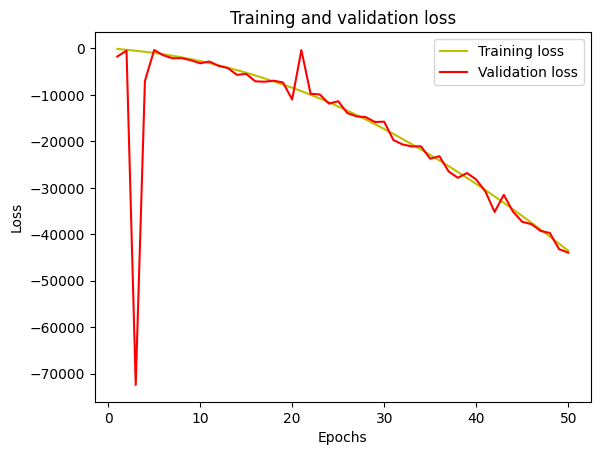

In [23]:
# Showing graph of training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Loading the model weights which got the highest "validation iou score"
from tensorflow import keras
final_model = keras.models.load_model('/content/model_save/weights-14-60.6919.hdf5', compile=False)

# Showing Results

In [28]:
def show_results(im_path , mk_path):
    val_img = cv2.imread(im_path, cv2.IMREAD_COLOR)       
    val_img = cv2.resize(val_img, (SIZE_Y, SIZE_X))
    val_img = cv2.cvtColor(val_img, cv2.COLOR_RGB2BGR)
    val_img = np.expand_dims(val_img, axis=0)
    #print(val_img.shape)

    prediction = final_model.predict(val_img)

    mask = cv2.imread(mk_path, 0)       
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    mask = np.expand_dims(mask , axis = 2)
    #print(mask.shape)

    prediction_image = prediction.reshape(mask.shape)
    img_to_show = val_img.reshape((SIZE_Y, SIZE_X, 3))

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))
    ax1.imshow(img_to_show)
    ax1.set_title('Original Image')

    ax2.imshow(mask , cmap='gray')
    ax2.set_title('Original Mask')

    ax3.imshow(prediction_image , cmap='gray')
    ax3.set_title('Predicted Mask')
    
    plt.show()

1/1 [==============================] - 0s 31ms/step


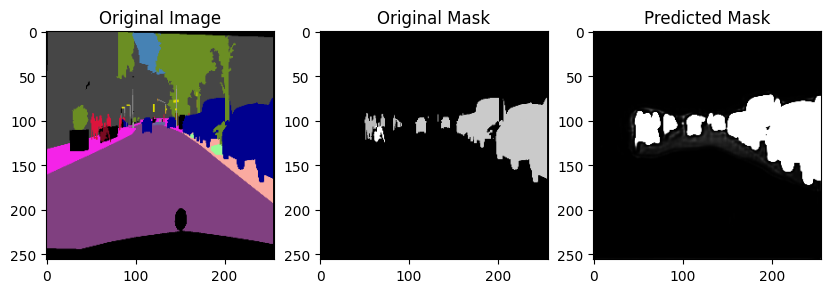

In [29]:
show_results(im_path = val_path['image'].iloc[0] , mk_path = val_path['mask'].iloc[0])

1/1 [==============================] - 0s 28ms/step


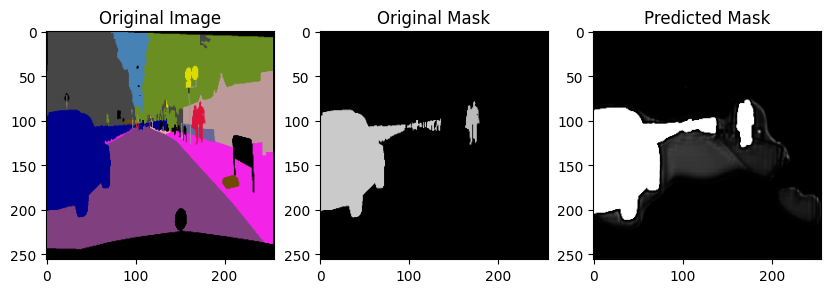

In [30]:
show_results(im_path = val_path['image'].iloc[27] , mk_path = val_path['mask'].iloc[27])

1/1 [==============================] - 0s 25ms/step


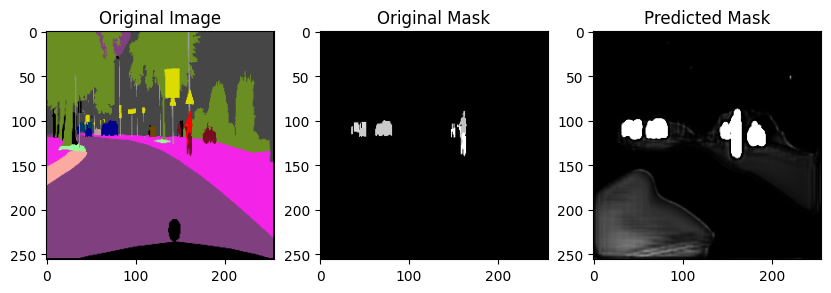

In [31]:
show_results(im_path = val_path['image'].iloc[347] , mk_path = val_path['mask'].iloc[347])

1/1 [==============================] - 0s 26ms/step


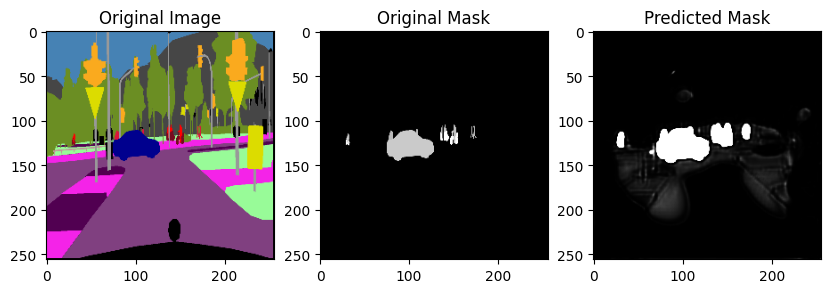

In [32]:
show_results(im_path = val_path['image'].iloc[412] , mk_path = val_path['mask'].iloc[412])

1/1 [==============================] - 0s 56ms/step


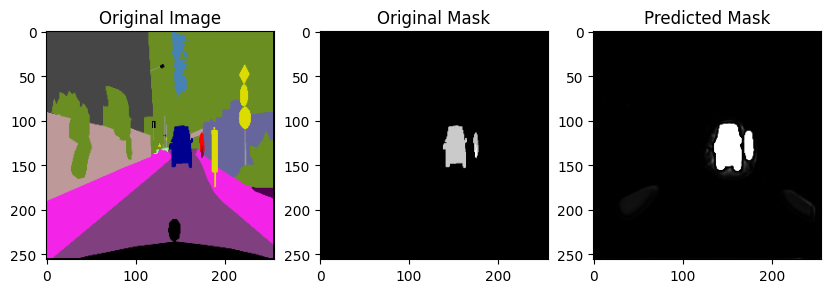

In [33]:
show_results(im_path = val_path['image'].iloc[271] , mk_path = val_path['mask'].iloc[271])